In [157]:
import tdmclient.notebook
await tdmclient.notebook.stop()

In [158]:
import matplotlib.pyplot as plt
import numpy as np
import heapq
import os
import asyncio
import tdmclient.notebook
await tdmclient.notebook.start()

In [159]:
class Maze():
    def __init__(self,img_file,start,end,width):
        self.img_file=img_file
        self.maze_img=plt.imread(self.img_file)
        self.maze_img_array = np.asarray(self.maze_img)
        self.maze_grid=self.flatten(self.maze_img_array)
        self.start=start
        self.end=end
        self.obstacles=set()
        self.obstaclesidx=set()
        self.width=width
        self.get_obstacles()

    def show(self):
        image = plt.imread(self.img_file)
        plt.imshow(image)
        plt.plot(self.start[1],self.start[0],'o')
        plt.plot(self.end[1],self.end[0],'x')


    def wall_string(self,x,y):
        return f'\t<wall x="{x}" y="{y}" l1="{self.width}" l2="{self.width}" h="10.00" color="red" angle="0" />\n'

    def place_robot(self, x, y):
        return f'\t<robot type="thymio2" x="{x}" y="{y}" port="33334" angle="-1.57" name="Tim" nodeId="1"/>\n'

    def define_area(self, x, y, name):
        return f'\t<area name="{name}">\n\t\t<point x="{x-10}" y="{y-10}" />\n\t\t<point x="{x+self.width}" y="{y-10}" />\n\
        \t\t<point x="{x+self.width}" y="{y+self.width}" />\n\
        \t\t<point x="{x-50}" y="{y+self.width}" />\n\t</area>\n'

    def flatten(self,np_array):
        return np_array[:,:,0]

    def write_playground(self):
        with open('RobM2023.playground','r') as firstfile, open('RobM2023_2.playground','w') as secondfile:
            lines = firstfile.readlines()
            lastline = lines[-1]
            lines = lines[:-1]
            for line in lines:
                secondfile.write(line)

            secondfile.write(self.place_robot(self.start[0]*self.width, self.start[1]*self.width))
            secondfile.write(self.define_area(self.start[0]*self.width, self.start[1]*self.width, 'start'))
            secondfile.write(self.define_area(self.end[0]*self.width, self.end[1]*self.width, 'end'))

            for i in range(len(self.maze_grid)):
                for j in range(len(self.maze_grid[0])):
                    if(self.maze_grid[i, j] == 0):
                        secondfile.write(self.wall_string(i*self.width + self.width/2, j*self.width + self.width/2))
            secondfile.writelines(lastline)

    def get_obstacles(self):
        for i in range(len(self.maze_grid)):
            for j in range(len(self.maze_grid[0])):
                if(self.maze_grid[i,j]==0):
                    self.obstacles.add((i*self.width,j*self.width))
                    self.obstaclesidx.add((i,j))
        return self.obstaclesidx,self.obstacles

    def isIndexValid(self,point):
        if point[0]>=0 and point[0]<len(self.maze_grid) and point[1]>=0 and point[1]<len(self.maze_grid[0]):
            if point not in self.obstaclesidx:
                return True
            else:
                return False
        else:
            return False

    def isValid(self,point):
        pass
        #if n[0]>=0 and n[0]<len(self.maze_grid) and n[1]>=0 and n[1]<<len(self.maze_grid[0]):
        #    if point not in self.maze.obstaclesidx:
        #        return True

In [160]:
class Planner:
    def __init__(self,maze):
        self.maze=maze

    def neighbors(self,point):
        nei=np.array([[1.0,0],[0,1],[-1,0],[0,-1]],dtype=float)
        neigs=nei+np.array([point[0],point[1]])
        valid_neigs=[]
        for n in neigs:
            if self.maze.isIndexValid(tuple(n)):
                valid_neigs.append(tuple(n))
        return valid_neigs

    def heuristic(self,p1,p2):
        return 0

    def plot_path(self,path):
        X, Y = map(list, zip(*path))
        plt.plot(Y,X)
        plt.plot(Y[0],X[0],'o')
        plt.plot(Y[-1],X[-1],'x')

    def a_star(self):
        self.path=[]
        self.frontier=[]
        self.visited=set()
        self.came_from={}
        self.iters=0

        if not (p.maze.isIndexValid(p.maze.start) and p.maze.isIndexValid(p.maze.end)):
            print('Invalid start or end')
            return
            # Initialize Heap
        c_s=0
        cur=self.maze.start
        heapq.heappush(self.frontier,(c_s+self.heuristic(cur,self.maze.end),cur))
        self.visited.add(cur)

        while(self.frontier and cur[1]!=self.maze.end):
            c_s+=1
            # Get next item in frontier
            cur=heapq.heappop(self.frontier)
            for n in self.neighbors(cur[1]):
                # Push neighbours into the frontier Heap
                if n not in self.visited:
                    heapq.heappush(self.frontier,(c_s+self.heuristic(cur[1],self.maze.end),n))
                    self.visited.add(n)
                    self.came_from[n]=cur[1]
                    self.iters+=1

                    #Start from the end and go back until start is reached
        cur = self.maze.end
        while cur!=self.maze.start:
            self.path.append(cur)
            cur=self.came_from[cur]
        self.path.append(cur)
        self.path.reverse()
        return self.path

    def a_star_v2(self):
        self.path=[]
        self.frontier=[]
        self.costs={}
        self.visited=set()
        self.iters=0
        self.came_from={}

        if not (p.maze.isIndexValid(p.maze.start) and p.maze.isIndexValid(p.maze.end)):
            print('Invalid start or end')
            return
            # Initialize Heap
        c_s=0
        cur=self.maze.start
        c_h=self.heuristic(cur,self.maze.end)
        c_t=c_s+c_h
        c=(c_t,c_s,c_h)
        heapq.heappush(self.frontier,(c,cur))
        self.visited.add(self.maze.start)
        self.costs[cur]=c

        #Add neighbors to heap and process them
        while(self.frontier and cur[1]!=self.maze.end):
            c_s+=1
            #get next item in frontier
            cur=heapq.heappop(self.frontier)
            for n in self.neighbors(cur[1]):
                if n not in self.visited:
                    #Calculate Costs:
                    c_h=self.heuristic(n,self.maze.end)
                    c_t=c_s+c_h
                    c=(c_t,c_s,c_h)
                    #put item in frontier
                    heapq.heappush(self.frontier,(c,n))
                    self.costs[n]=c
                    self.visited.add(n)
                    self.came_from[n]=cur[1]
                    self.iters+=1

        #Start from the end:
        self.path=[self.maze.end]
        cur=self.maze.end
        while cur!=self.maze.start:
            min_cost=9999
            for n in self.neighbors(cur):
                if n in self.costs and n not in self.path and self.costs[n][0]<=min_cost:
                    lowest_neigh=n
                    min_cost=self.costs[n][0]
            self.path.append(lowest_neigh)
            cur=lowest_neigh

        self.path.reverse()
        return self.path

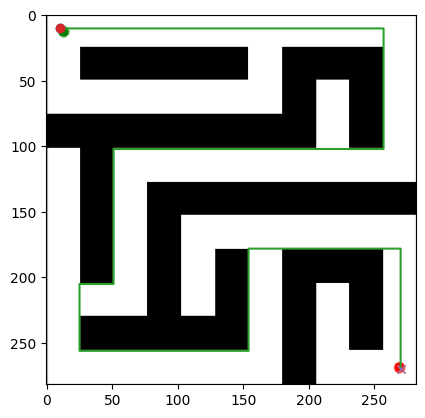

In [161]:

m=Maze('images/maze.png',start=(10,10),end=(270,270),width=282)
#m.write_playground()
p=Planner(m)
p.maze.show()

shortest_path = p.a_star()
if shortest_path:
    shortest_path_coordinates = [(point[0], point[1]) for point in shortest_path]
    #print(shortest_path_coordinates)
    p.plot_path(shortest_path)

In [162]:
def calculate_direction(point1, point2):
    x1, y1 = point1
    x2, y2 = point2

    delta_x = x2 - x1
    delta_y = y2 - y1

    if delta_x > 0:
        direction = "down"
    elif delta_x < 0:
        direction = "up"
    else:
        if delta_y > 0:
            direction = "right"
        elif delta_y < 0:
            direction = "left"

    return direction

In [163]:
%%run_python
@onevent
def left():
    global motor_left_target, motor_right_target
    motor_left_target = 50
    motor_right_target = 100


In [164]:
%%run_python
@onevent
def right():
    global motor_right_target, motor_left_target
    motor_right_target = 50
    motor_left_target = 100

In [165]:
%%run_python
@onevent
def forward():
    global motor_right_target, motor_left_target
    motor_right_target = 100
    motor_left_target = 100

In [166]:
def turn_left():
    send_event("left")

def turn_right():
    send_event("right")
    
def go_forward():
    send_event("forward")

def move_robot(direction):
    if direction == "forward":
        go_forward()
    # elif direction == "down":
    #     move_backward()
    elif direction == "left":
        turn_left()
    elif direction == "right":
        turn_right()

In [167]:
import time

for i in range(243, len(shortest_path_coordinates)):
    direction = calculate_direction(shortest_path_coordinates[i - 1], shortest_path_coordinates[i])
    print(shortest_path_coordinates[i])

    if i < len(shortest_path_coordinates) - 1:
        next_direction = calculate_direction(shortest_path_coordinates[i], shortest_path_coordinates[i + 1])
        print(f"Current direction: {direction}, Next direction: {next_direction}")

        if next_direction != direction:
            # Turn the robot based on the change in direction
            print(f"Turn {direction} to {next_direction}")
            move_robot(next_direction)
            if direction == "right" and next_direction == "down":
                move_robot("right")
            elif direction == "left" and next_direction == "down":
                move_robot("left")
            elif direction == "right" and next_direction == "up":
                move_robot("left")
            elif direction == "left" and next_direction == "up":
                move_robot("right")
        else:
            # Move the robot forward if the direction is the same
            print("Move forward")
            move_robot("forward")

        # Add a delay after each movement
        time.sleep(2)

    else:
        # Move the robot in the final direction
        print(f"Move in the final direction: {direction}")
        move_robot(direction)

    # Add a delay before the next iteration
    time.sleep(2)

(10.0, 253.0)
Current direction: right, Next direction: right
Move forward
(10.0, 254.0)
Current direction: right, Next direction: right
Move forward
(10.0, 255.0)
Current direction: right, Next direction: right
Move forward
(10.0, 256.0)
Current direction: right, Next direction: right
Move forward
(10.0, 257.0)
Current direction: right, Next direction: down
Turn right to down
(11.0, 257.0)
Current direction: down, Next direction: down
Move forward
(12.0, 257.0)
Current direction: down, Next direction: down
Move forward


KeyboardInterrupt: 